In [74]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
import torch
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import Counter


# Apply tqdm to all .apply() functions by using progress_apply
tqdm.pandas()

In [2]:
# Use GPU if available
"""
Reference: https://pytorch.org/get-started/locally/
"""

# Check for NVIDIA GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA (NVIDIA GPU)
    print("Using NVIDIA GPU (CUDA)")

# Check for Mac Silicon GPU (MPS)
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal Performance Shaders (Mac Silicon GPU)
    print("Using Mac GPU (MPS)")

# Default to CPU if no GPU is available
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Mac GPU (MPS)


In [3]:
# Reading the dataset
alexator_df = pd.read_csv('../data/alexator_stickers_desc.csv')
flaticon_df = pd.read_csv('../data/flaticon_stickers_desc.csv')
freepik_df = pd.read_csv('../data/freepik_stickers_desc.csv')

In [4]:
alexator_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     4331 non-null   object
 1   description  4331 non-null   object
dtypes: object(2)
memory usage: 67.8+ KB


In [5]:
flaticon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30402 entries, 0 to 30401
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        30402 non-null  object
 1   title        30402 non-null  object
 2   tags         30402 non-null  object
 3   filename     30402 non-null  object
 4   description  30402 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [6]:
freepik_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9844 entries, 0 to 9843
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        0 non-null      float64
 1   tags         9814 non-null   object 
 2   image        9844 non-null   object 
 3   filename     9844 non-null   object 
 4   description  9844 non-null   object 
dtypes: float64(1), object(4)
memory usage: 384.7+ KB


In [7]:
# Concatenate the DataFrames row-wise
merged_df = pd.concat([alexator_df, flaticon_df, freepik_df], ignore_index=True)

# Display the concatenated DataFrame
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44577 entries, 0 to 44576
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     44577 non-null  object
 1   description  44577 non-null  object
 2   image        40246 non-null  object
 3   title        30402 non-null  object
 4   tags         40216 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


## Handling duplicates in description and tags combination


In [8]:
# Replace duplicate descriptions with Null (Because most of them don't make sense and are incorrect)
duplicate_descriptions = merged_df['description'].duplicated(keep=False)
merged_df.loc[duplicate_descriptions, 'description'] = None

"""Some generated descriptions have errors such as "a big boy boy boy boy boy...."
So, we want to remove such descriptions that have incorrect descriptions
"""

"""
Reference: ChatGPT-4o
Prompt:  I need to check for a certain type of error and remove those rows in my dataframe. The error is that in some description, certain words are repeated multiple time consecutively. Example: "happy man with two polar polar polar polar polar polar polar polar polar polar polar polar polar polar polar polar polar"
"""
# Replace descriptions with repeated words with Null
def has_repeated_words(text):
    if not text or pd.isna(text):  # Skip null or empty strings
        return False
    
    # Regex to find words repeated consecutively at least 3 times (case insensitive)
    pattern = r'\b(\w+)(?:\s+\1){2,}\b'
    return bool(re.search(pattern, text, re.IGNORECASE))

merged_df.loc[merged_df['description'].apply(has_repeated_words), 'description'] = None

# Remove rows with exact same tags AND description, keeping the first occurrence (We don't want different immages with same details)
cleaned_df = merged_df.drop_duplicates(subset=['tags', 'description'], keep='first')

# Check the new number of rows
print(f"Number of rows after removing rows with exact same tags and descriptions: {cleaned_df.shape[0]}")

Number of rows after removing rows with exact same tags and descriptions: 38807


In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38807 entries, 0 to 44576
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     38807 non-null  object
 1   description  26858 non-null  object
 2   image        35101 non-null  object
 3   title        27135 non-null  object
 4   tags         35091 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


## Handling Tags and Descriptions

In [16]:
def remove_duplicates(text):
    if not isinstance(text, str) or pd.isna(text) or text.strip().lower() == "nan":  
        return ""  # Return empty string for NaN or "nan" strings
    words = [word.strip() for word in text.split(",")]  # Split by commas and strip spaces
    unique_words = sorted(set(word.strip() for word in text.split(",")))
    return ', '.join(unique_words)  # Join back into a string

In [17]:
# Remove duplicates
final_df = cleaned_df.copy()
final_df["tags"] = final_df["tags"].progress_apply(remove_duplicates)

100%|██████████| 38807/38807 [00:00<00:00, 389694.45it/s]


In [18]:
### Need to conduct spelling correction in description column here as well

In [19]:
# Function to handle concatenation with empty strings and NaN values
def merge_descriptions(row):
    parts = []
    if pd.notna(row['description']) and row['description'].strip():
        parts.append(row['description'].strip())
    if pd.notna(row['tags']) and row['tags'].strip():
        parts.append("Tags: " + row['tags'].strip())
    
    return " ".join(parts)

# Apply the function to each row
final_df['merged_description'] = final_df.apply(merge_descriptions, axis=1)

## Exploratory Business Analysis

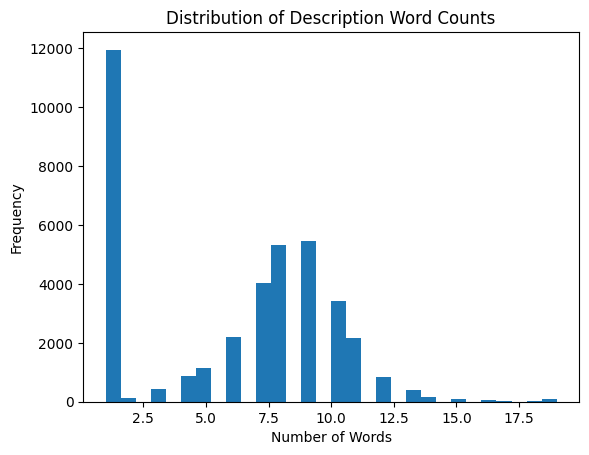

In [73]:
# Text Length Distribution
final_df["desc_length"] = final_df["description"].apply(lambda x: len(str(x).split()))

plt.hist(final_df["desc_length"], bins=30)
plt.title("Distribution of Description Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [75]:
# Tag Frequency Analysis
tag_list = final_df['tags'].dropna().apply(lambda x: [tag.strip() for tag in x.split(",")])
all_tags = [tag for sublist in tag_list for tag in sublist]

top_tags = Counter(all_tags).most_common(20)

print("Top 20 tags:")
print(top_tags)

Top 20 tags:
[('animals', 6864), ('smileys', 5252), ('', 3716), ('animal', 3280), ('miscellaneous', 2452), ('people', 2450), ('food and restaurant', 2278), ('sticker', 1864), ('celebration', 1845), ('pet', 1842), ('cute', 1663), ('love', 1651), ('1+ tags', 1625), ('cultures', 1489), ('education', 1456), ('cat', 1340), ('nature', 1339), ('holidays', 1335), ('bunny', 1284), ('party', 1192)]


## Embedding using Sentence BERT

In [20]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model = sbert_model.to(device)

# Return SBERT embedding for a given text.
def embed_text(text):
    if pd.isna(text) or text.strip() == "":
        return np.zeros(384, dtype=np.float32)  # Return zero vector for missing values (SBERT output size = 384)
    return sbert_model.encode(text).astype(np.float32)

In [21]:
"""
Reference: https://sbert.net/
"""

# Apply SBERT embeddings to each columns
# print("Embedding tags...")
# final_df["tags_embedding"] = final_df["tags"].progress_apply(embed_text)
# 
# print("Embedding llm_description...")
# final_df["description_embedding"] = final_df["description"].progress_apply(embed_text)
print("Embedding text...")
final_df["combined_embedding"] = final_df["merged_description"].progress_apply(embed_text)

Embedding text...


100%|██████████| 38807/38807 [05:53<00:00, 109.68it/s]


In [22]:
# # Combining the embeddings
# final_df["combined_embedding"] = final_df.apply(
#     lambda row: np.concatenate([row["tags_embedding"], row["description_embedding"]]), axis=1
# )

## Linking Images

In [23]:
final_df.head()

,filename,description,image,title,tags,merged_description,combined_embedding
0,cartoonized_image_0.png,a red mailbox with a white background,NaN,NaN,,a red mailbox with a white background,"[0.056150362, 0.06784807, -0.03342954, 0.03755..."
1,cartoonized_image_1.png,an old car sticker,NaN,NaN,,an old car sticker,"[-0.124234304, 0.07463952, -0.011985379, 0.004..."
2,cartoonized_image_10.png,None,NaN,NaN,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,cartoonized_image_100.png,a sticker with a cartoon pine wearing glasses,NaN,NaN,,a sticker with a cartoon pine wearing glasses,"[-0.06495427, -0.04292715, 0.013164389, 0.0220..."
4,cartoonized_image_1000.png,a stained stained glass window with a humming,NaN,NaN,,a stained stained glass window with a humming,"[0.02791825, 0.075559355, 0.036227103, -0.0181..."


In [24]:
# Change file extensions from .png to .pt in the 'filename' column
final_df['filename'] = final_df['filename'].str.replace('.png', '.pt', regex=False)

# Display the first few rows to verify changes
final_df['filename'].head()

0       cartoonized_image_0.pt
1       cartoonized_image_1.pt
2      cartoonized_image_10.pt
3     cartoonized_image_100.pt
4    cartoonized_image_1000.pt
Name: filename, dtype: object

In [25]:
# Define the base directory and folders to search in
base_dir = "../data/tensor_images/"
folders = ["AlexatorStickers", "FlaticonStickers", "FreepikStickers"]

# Function to find the file path for a given filename
def find_image_path(filename):
    # Loop through each folder
    for folder in folders:
        # Construct full path
        full_path = os.path.join(base_dir, folder, filename)
        # Check if file exists at this path
        if os.path.exists(full_path):
            return full_path
    # Return None if file not found in any folder
    return None

# Create the new column by applying the function to the filename column
final_df['image_path'] = final_df['filename'].progress_apply(find_image_path)

# Display a sample of the DataFrame to verify
final_df.head()

100%|██████████| 38807/38807 [00:00<00:00, 86046.98it/s] 


,filename,description,image,title,tags,merged_description,combined_embedding,image_path
0,cartoonized_image_0.pt,a red mailbox with a white background,NaN,NaN,,a red mailbox with a white background,"[0.056150362, 0.06784807, -0.03342954, 0.03755...",../data/tensor_images/AlexatorStickers/cartoon...
1,cartoonized_image_1.pt,an old car sticker,NaN,NaN,,an old car sticker,"[-0.124234304, 0.07463952, -0.011985379, 0.004...",../data/tensor_images/AlexatorStickers/cartoon...
2,cartoonized_image_10.pt,None,NaN,NaN,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",../data/tensor_images/AlexatorStickers/cartoon...
3,cartoonized_image_100.pt,a sticker with a cartoon pine wearing glasses,NaN,NaN,,a sticker with a cartoon pine wearing glasses,"[-0.06495427, -0.04292715, 0.013164389, 0.0220...",../data/tensor_images/AlexatorStickers/cartoon...
4,cartoonized_image_1000.pt,a stained stained glass window with a humming,NaN,NaN,,a stained stained glass window with a humming,"[0.02791825, 0.075559355, 0.036227103, -0.0181...",../data/tensor_images/AlexatorStickers/cartoon...


In [26]:
final_df.tail()

,filename,description,image,title,tags,merged_description,combined_embedding,image_path
44568,e774c692161b72d9aec20c3fbf428cd3.pt,None,https://cdn-icons-png.freepik.com/512/5265/526...,NaN,"1+ tags, acorn, autumn, fall, nature, nut, oak","Tags: 1+ tags, acorn, autumn, fall, nature, nu...","[0.016550789, -0.01920497, 0.02788188, 0.01634...",../data/tensor_images/FreepikStickers/e774c692...
44572,45315ce4e6c47ea63d48cc2803c3b573.pt,None,https://cdn-icons-png.freepik.com/512/9237/923...,NaN,"forgiveness, lettering, miscellaneous, text, t...","Tags: forgiveness, lettering, miscellaneous, t...","[-0.010662382, 0.06505608, 0.0015260449, -0.04...",../data/tensor_images/FreepikStickers/45315ce4...
44573,45490b44eab46e6c55b9db2e2fddebba.pt,you got this by thepaper,https://cdn-icons-png.freepik.com/512/7234/723...,NaN,"1+ tags, letter, lettering, sticker, stickers,...","you got this by thepaper Tags: 1+ tags, letter...","[-0.06165752, 0.03242149, -0.033661354, 0.0193...",../data/tensor_images/FreepikStickers/45490b44...
44575,6416c3089f405d5ff3ef13d329d56694.pt,None,https://cdn-icons-png.freepik.com/512/13560/13...,NaN,"chef, cooking, kitchen utensils, kitchenware, ...","Tags: chef, cooking, kitchen utensils, kitchen...","[-0.02658946, -0.0327129, -0.044376384, 0.0242...",../data/tensor_images/FreepikStickers/6416c308...
44576,39ba1481c3d87a7feaf269ab5b2166c5.pt,None,https://cdn-icons-png.freepik.com/512/5700/570...,NaN,"1+ tags, dress, fashion, follower, marketing, ...","Tags: 1+ tags, dress, fashion, follower, marke...","[0.0001645737, -0.07497659, -0.041260988, 0.00...",../data/tensor_images/FreepikStickers/39ba1481...


In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38807 entries, 0 to 44576
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   filename            38807 non-null  object
 1   description         26858 non-null  object
 2   image               35101 non-null  object
 3   title               27135 non-null  object
 4   tags                38807 non-null  object
 5   merged_description  38807 non-null  object
 6   combined_embedding  38807 non-null  object
 7   image_path          38807 non-null  object
dtypes: object(8)
memory usage: 2.7+ MB


In [28]:
final_df[['combined_embedding', 'image_path']].to_parquet('../data/processed_sticker_dataset.parquet', index=False)